### Causal Multi-Head Self-Attention  

#### 1.为什么需要“多头”  
- 在单头注意力中，模型只能通过一组QKV矩阵学习相关性。这就像只派一个侦探去破案，他可能只盯着嫌疑人的“指纹”，却忽略了其他细节  
- 多头注意力机制允许模型同时关注多个不同的部分，从而提高模型的性能  
- 结果融合：通过最后的线性投影层，将这些并行提取的信息重新整合

#### 2.维度变化  
- 核心任务是确保张量形状在拆分和合并过程中完全对齐  
- 假设模型的隐藏层总维度（$d_model$）为512。设置8个头，那么每个头为64维。这意味每个侦探处理的信息量变小了，但总的计算成本与单头是接近的  


- 假设我们输入了一个长度为2的句子[Thinking,Machines]  
1. 初始化参数：  
   - 输入序列长度：2个词元 
   - 模型隐藏层维度：512  
   - 注意力头数： 8  
   - 每个头维度：  64
2. 局部计算演示：  
   - 投影：模型拿词元Thinking的嵌入向量，乘以第一个头的三个矩阵Q，K，V（大小均为512*64），得到该词元在第一个头下的向量为q.k.v，长度为64  
   - 打分：计算$q_1\cdot k_1^T$和$q_2\cdot k_2^T$，得到两个得分，长度为64。假设得分为112和96  
   - 缩放与归一化。将分数除以 8。经过softmax变化后，注意力权重假设为0.88和0.12  
   - 提取信息:将权重作用于值向量$v_1$和$v_2$，加权求和得到第一个头的输出$Z_1$  
3. 汇总结果  
   - 模型并行计算$z_1$至$z_8$
   - 将这8个64维的向量水平拼接后，形成一个512维的矩阵  
   - 通过投影后，输出全局信息的新向量表示

In [1]:
import torch 
import torch.nn as nn 
import torch.nn.functional as F

In [2]:
torch.manual_seed(42)  # 固定随机种子，每次运行结果完全一致
batch_size = 1         # 批量设为1
seq_len = 4            # 短序列
d_model = 8            # 总特征维度
n_heads = 2            # 头数，要求d_model % n_heads == 0（8%2=0）
d_k = d_model // n_heads  # 每个头的维度，4=8//2

print(f"批量大小：{batch_size} | 序列长度：{seq_len} | 总特征维度：{d_model}")
print(f"头数：{n_heads} | 单头维度：{d_k}（d_model / n_heads）")

批量大小：1 | 序列长度：4 | 总特征维度：8
头数：2 | 单头维度：4（d_model / n_heads）


In [3]:
x=torch.randn(batch_size,seq_len,d_model)
print(x.shape)

torch.Size([1, 4, 8])


In [4]:
#QKV线性投影  
w_q=nn.Linear(d_model,d_model,bias=False)
w_k=nn.Linear(d_model,d_model,bias=False)
w_v=nn.Linear(d_model,d_model,bias=False)

for layer in [w_q,w_k,w_v]:
  nn.init.xavier_uniform_(layer.weight)

Q=w_q(x)
K=w_k(x)
V=w_v(x)

print(Q.shape,K.shape,V.shape)
print(f"Q数值（保留3位小数）：\n{torch.round(Q, decimals=3)}")
print(f"K数值（保留3位小数）：\n{torch.round(K, decimals=3)}")
print(f"V数值（保留3位小数）：\n{torch.round(V, decimals=3)}")

torch.Size([1, 4, 8]) torch.Size([1, 4, 8]) torch.Size([1, 4, 8])
Q数值（保留3位小数）：
tensor([[[-0.8710,  2.8080,  0.8150,  2.2170,  1.0410,  2.7240,  2.6920,
          -0.9380],
         [ 2.0180,  0.5170,  0.6440,  1.4120, -2.0860,  0.5170,  0.0090,
           1.0650],
         [-1.1570, -1.5710,  0.0070, -1.8270, -0.3720, -0.9090, -0.0240,
           0.0830],
         [ 0.9250,  1.0680, -0.3320, -0.9040, -0.0360,  0.3920,  0.7540,
          -0.4600]]], grad_fn=<RoundBackward1>)
K数值（保留3位小数）：
tensor([[[ 2.2000,  0.0570, -1.4420, -1.1430,  0.0710,  0.0290,  1.2090,
          -1.2940],
         [ 0.1380,  0.5720,  0.9930, -0.1220, -0.0890, -0.1680,  0.6880,
           0.3570],
         [ 0.1770, -1.4410,  0.4390, -0.6500, -2.3530, -1.6110, -1.3410,
          -0.0140],
         [-0.0870, -1.1630,  0.2450,  0.2690, -0.3570, -0.7930, -0.3630,
          -0.7450]]], grad_fn=<RoundBackward1>)
V数值（保留3位小数）：
tensor([[[ 0.1430, -0.7580, -0.9770,  2.3200,  1.6900,  2.1880,  1.3480,
           0.6170],
  

In [5]:
#拆分Q/K/V 
def split_heads(tensor, n_heads):
    """按头拆分函数"""
    batch, seq_len, d_model = tensor.shape
    d_k = d_model // n_heads
    # 步骤1：reshape展平维度 → [batch, seq_len, n_heads, d_k]
    tensor = tensor.reshape(batch, seq_len, n_heads, d_k)
    # 步骤2：转置头和序列维度 → [batch, n_heads, seq_len, d_k]（头优先）
    tensor = tensor.transpose(1, 2)
    return tensor

# 拆分Q/K/V
Q_split = split_heads(Q, n_heads)
K_split = split_heads(K, n_heads)
V_split = split_heads(V, n_heads)
print(f"拆分后Q形状：{Q_split.shape} | K形状：{K_split.shape} | V形状：{V_split.shape}")
print(f"拆分后Q（头0+头1，保留3位小数）：\n{torch.round(Q_split, decimals=3)}")


拆分后Q形状：torch.Size([1, 2, 4, 4]) | K形状：torch.Size([1, 2, 4, 4]) | V形状：torch.Size([1, 2, 4, 4])
拆分后Q（头0+头1，保留3位小数）：
tensor([[[[-0.8710,  2.8080,  0.8150,  2.2170],
          [ 2.0180,  0.5170,  0.6440,  1.4120],
          [-1.1570, -1.5710,  0.0070, -1.8270],
          [ 0.9250,  1.0680, -0.3320, -0.9040]],

         [[ 1.0410,  2.7240,  2.6920, -0.9380],
          [-2.0860,  0.5170,  0.0090,  1.0650],
          [-0.3720, -0.9090, -0.0240,  0.0830],
          [-0.0360,  0.3920,  0.7540, -0.4600]]]], grad_fn=<RoundBackward1>)


In [6]:
#生成因果掩码
causal_mask = torch.triu(torch.ones(seq_len, seq_len), diagonal=1).bool()
print(f"掩码形状：{causal_mask.shape}（可广播到所有头）")
print(f"因果掩码矩阵（True=屏蔽，False=保留）：\n{causal_mask}")

掩码形状：torch.Size([4, 4])（可广播到所有头）
因果掩码矩阵（True=屏蔽，False=保留）：
tensor([[False,  True,  True,  True],
        [False, False,  True,  True],
        [False, False, False,  True],
        [False, False, False, False]])


In [7]:
#分头计算缩放点积注意力分数
scale = torch.sqrt(torch.tensor(d_k, dtype=torch.float32))
# 核心计算：Q@K^T（最后两维转置），再缩放
# K_split.transpose(-2,-1)：将每个头的K转置为[4,4]
attn_scores = torch.matmul(Q_split, K_split.transpose(-2, -1)) / scale
print(f"缩放因子：√d_k = {scale.item():.3f}（单头维度缩放，非总维度）")
print(f"注意力分数形状：{attn_scores.shape}")
print(f"头0的注意力分数（保留3位小数）：\n{torch.round(attn_scores[0,0], decimals=3)}")
print(f"头1的注意力分数（保留3位小数）：\n{torch.round(attn_scores[0,1], decimals=3)}")

缩放因子：√d_k = 2.000（单头维度缩放，非总维度）
注意力分数形状：torch.Size([1, 2, 4, 4])
头0的注意力分数（保留3位小数）：
tensor([[-2.7330,  1.0130, -2.6430, -1.1970],
        [ 0.9630,  0.5210, -0.5120, -0.1190],
        [-0.2780, -0.4150,  1.6250,  0.7190],
        [ 1.8030,  0.2600, -0.4670, -0.8240]], grad_fn=<RoundBackward1>)
头1的注意力分数（保留3位小数）：
tensor([[ 2.3110,  0.4840, -5.2160, -1.4040],
        [-0.7500,  0.2430,  2.0250, -0.2300],
        [-0.0940,  0.0990,  1.1850,  0.4000],
        [ 0.7580,  0.1460, -0.7750, -0.1140]], grad_fn=<RoundBackward1>)


In [8]:
#分头因果掩码
masked_value = -1e9
attn_scores_masked = attn_scores.masked_fill(causal_mask, masked_value)
print(f"掩码填充值：{masked_value}（exp({masked_value})≈0，避免数值溢出）")
print(f"掩码后分数形状：{attn_scores_masked.shape}")
print(f"头0掩码后分数（保留3位小数，上三角为{masked_value:.0f}）：\n{torch.round(attn_scores_masked[0,0], decimals=3)}")
print(f"头1掩码后分数（保留3位小数，上三角为{masked_value:.0f}）：\n{torch.round(attn_scores_masked[0,1], decimals=3)}")

掩码填充值：-1000000000.0（exp(-1000000000.0)≈0，避免数值溢出）
掩码后分数形状：torch.Size([1, 2, 4, 4])
头0掩码后分数（保留3位小数，上三角为-1000000000）：
tensor([[-2.7330e+00, -1.0000e+09, -1.0000e+09, -1.0000e+09],
        [ 9.6300e-01,  5.2100e-01, -1.0000e+09, -1.0000e+09],
        [-2.7800e-01, -4.1500e-01,  1.6250e+00, -1.0000e+09],
        [ 1.8030e+00,  2.6000e-01, -4.6700e-01, -8.2400e-01]],
       grad_fn=<RoundBackward1>)
头1掩码后分数（保留3位小数，上三角为-1000000000）：
tensor([[ 2.3110e+00, -1.0000e+09, -1.0000e+09, -1.0000e+09],
        [-7.5000e-01,  2.4300e-01, -1.0000e+09, -1.0000e+09],
        [-9.4000e-02,  9.9000e-02,  1.1850e+00, -1.0000e+09],
        [ 7.5800e-01,  1.4600e-01, -7.7500e-01, -1.1400e-01]],
       grad_fn=<RoundBackward1>)


In [9]:
# 分头计算softmax注意力权重
attn_weights = F.softmax(attn_scores_masked, dim=-1)
# 计算每个头的每行权重和（验证归一化正确性）
head0_row_sums = torch.sum(attn_weights[0,0], dim=-1)
head1_row_sums = torch.sum(attn_weights[0,1], dim=-1)
print(f"注意力权重形状：{attn_weights.shape}")
print(f"头0注意力权重（保留3位小数，上三角全0）：\n{torch.round(attn_weights[0,0], decimals=3)}")
print(f"头1注意力权重（保留3位小数，上三角全0）：\n{torch.round(attn_weights[0,1], decimals=3)}")
print(f"头0每行权重和（验证归一化，应均为1）：\n{torch.round(head0_row_sums, decimals=3)}")
print(f"头1每行权重和（验证归一化，应均为1）：\n{torch.round(head1_row_sums, decimals=3)}")

注意力权重形状：torch.Size([1, 2, 4, 4])
头0注意力权重（保留3位小数，上三角全0）：
tensor([[1.0000, 0.0000, 0.0000, 0.0000],
        [0.6090, 0.3910, 0.0000, 0.0000],
        [0.1170, 0.1020, 0.7820, 0.0000],
        [0.7200, 0.1540, 0.0740, 0.0520]], grad_fn=<RoundBackward1>)
头1注意力权重（保留3位小数，上三角全0）：
tensor([[1.0000, 0.0000, 0.0000, 0.0000],
        [0.2700, 0.7300, 0.0000, 0.0000],
        [0.1720, 0.2090, 0.6190, 0.0000],
        [0.4600, 0.2490, 0.0990, 0.1920]], grad_fn=<RoundBackward1>)
头0每行权重和（验证归一化，应均为1）：
tensor([1., 1., 1., 1.], grad_fn=<RoundBackward1>)
头1每行权重和（验证归一化，应均为1）：
tensor([1., 1., 1., 1.], grad_fn=<RoundBackward1>)


In [10]:
# 分头注意力权重输出
attn_output_per_head = torch.matmul(attn_weights, V_split)
print(f"分头输出形状：{attn_output_per_head.shape}")
print(f"头0输出（保留3位小数）：\n{torch.round(attn_output_per_head[0,0], decimals=3)}")
print(f"头1输出（保留3位小数）：\n{torch.round(attn_output_per_head[0,1], decimals=3)}")

分头输出形状：torch.Size([1, 2, 4, 4])
头0输出（保留3位小数）：
tensor([[ 0.1430, -0.7580, -0.9770,  2.3200],
        [ 0.4230, -0.8310, -0.5330,  1.8890],
        [ 1.1870, -0.7920, -1.4560,  0.3220],
        [ 0.4030, -0.8280, -0.8060,  1.8720]], grad_fn=<RoundBackward1>)
头1输出（保留3位小数）：
tensor([[ 1.6900,  2.1880,  1.3480,  0.6170],
        [ 1.3040,  0.9960,  1.3800,  0.0570],
        [ 0.0000,  0.8110, -0.5890, -0.4940],
        [ 0.9470,  1.2750,  0.8430, -0.0510]], grad_fn=<RoundBackward1>)


In [11]:
#拼接所有输出
def concat_heads(tensor, n_heads):
    """拼接头函数（无封装，可直接看逻辑）"""
    batch, n_heads, seq_len, d_k = tensor.shape
    d_model = n_heads * d_k
    # 步骤1：转置还原序列和头维度 → [batch, seq_len, n_heads, d_k]
    tensor = tensor.transpose(1, 2)
    # 步骤2：reshape拼接头维度 → [batch, seq_len, d_model]
    tensor = tensor.reshape(batch, seq_len, d_model)
    return tensor

# 拼接所有头
attn_output_concat = concat_heads(attn_output_per_head, n_heads)
print(f"拼接前形状：{attn_output_per_head.shape}")
print(f"拼接后形状：{attn_output_concat.shape}（与原始输入维度一致）")
print(f"拼接后输出（保留3位小数）：\n{torch.round(attn_output_concat, decimals=3)}")

拼接前形状：torch.Size([1, 2, 4, 4])
拼接后形状：torch.Size([1, 4, 8])（与原始输入维度一致）
拼接后输出（保留3位小数）：
tensor([[[ 0.1430, -0.7580, -0.9770,  2.3200,  1.6900,  2.1880,  1.3480,
           0.6170],
         [ 0.4230, -0.8310, -0.5330,  1.8890,  1.3040,  0.9960,  1.3800,
           0.0570],
         [ 1.1870, -0.7920, -1.4560,  0.3220,  0.0000,  0.8110, -0.5890,
          -0.4940],
         [ 0.4030, -0.8280, -0.8060,  1.8720,  0.9470,  1.2750,  0.8430,
          -0.0510]]], grad_fn=<RoundBackward1>)


In [12]:
#最终线性投影
w_o = nn.Linear(d_model, d_model, bias=False)
nn.init.xavier_uniform_(w_o.weight)
final_output = w_o(attn_output_concat)
print(f"最终输出形状：{final_output.shape}（与输入完全一致）")
print(f"因果多头自注意力最终输出（保留3位小数）：\n{torch.round(final_output, decimals=3)}")

最终输出形状：torch.Size([1, 4, 8])（与输入完全一致）
因果多头自注意力最终输出（保留3位小数）：
tensor([[[-0.3470,  0.1430, -1.3200, -1.2200, -0.1790,  0.6190,  0.7850,
           0.6190],
         [ 0.2460,  0.1750, -1.0990, -0.6620,  0.4690,  0.7870,  0.3790,
           0.1870],
         [ 0.6530,  0.0240, -0.5590,  1.0530,  0.2640, -0.8090, -0.0120,
           0.0520],
         [ 0.1930,  0.0860, -1.1890, -0.4920, -0.0200,  0.3530,  0.3080,
           0.4850]]], grad_fn=<RoundBackward1>)


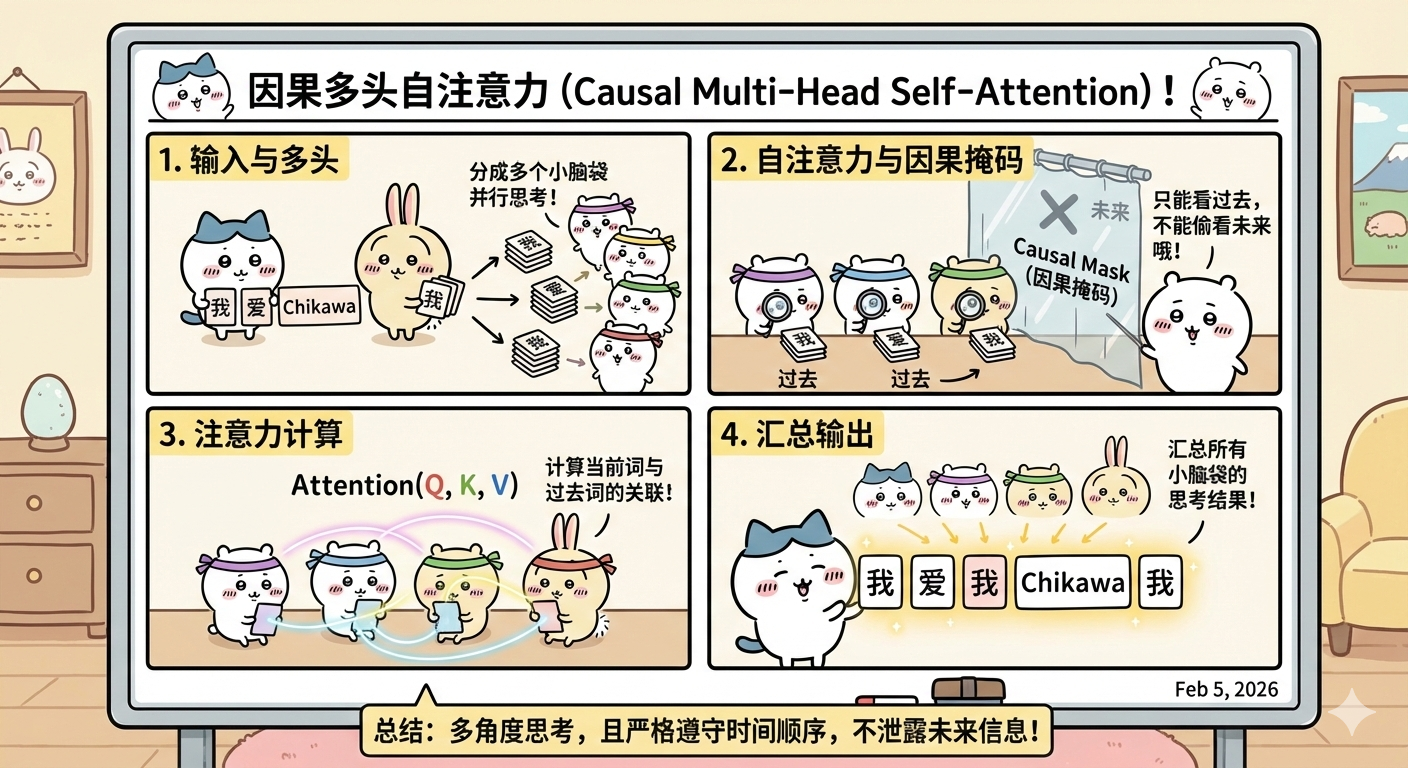